In [ ]:
# Thermalization-inspired training of Restricted Boltzmann machines
## Notebook 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def prob_to_binary(probs):
    return np.random.binomial(1,probs)

# RBM which encodes probabilities instead of binary values 

The RBM is also set up so that it can interact with a bath

In [3]:
class RBMProb:
    """A probabilistic implementation of a Restricted Boltzmann Machine."""
    def __init__(self, num_v = 4, num_h = 4, mixing_param = 0.1):
       
        #internal parameters
        self.num_v = num_v
        self.num_h = num_h
        
        #initial biases/couplings are random
        self.b_v = np.random.uniform(size = (num_v,))
        self.b_h = np.random.uniform(size = (num_h,)) 
        self.w = np.random.uniform(size = (num_v,num_h))
        
        #initial state of visible and hidden units is random
        self.visible_probs = np.random.uniform(size = (num_v,))
        self.hidden_probs = np.random.uniform(size = (num_h,))            
        
        #mixing parameter
        self.mixing_param = mixing_param

    def __str__(self):
        stateString = 'vis_probs: \n' + str(self.visible_probs) + '\n' + 'hid_probs: \n'+ str(self.hidden_probs) + '\n' 
        return stateString
                
    def evolve(self, num_steps, print_states = True):
        #internal evolution of RBM
        
        m = self.mixing_param
        
        if print_states:
            print 'Initial state: '
            print self
        
        for ctr in range(0,num_steps):
            #perform update
            self.hidden_probs = m*self.visible_probs + (1-m)*self.hidden_probs
            self.visible_probs = m*self.hidden_probs + (1-m)*self.visible_probs

        if print_states:        
            print '\nFinal state: '
            print self

    def interact_with_bath(self, bath):
        
        m = self.mixing_param
        
        if bath.rep == 'probability':
            self.visible_probs = bath.probs
        elif bath.rep == 'binary':
            self.visible_probs = m*bath.state + (1-m)*self.visible_probs

# Define simple bath models

In [4]:
class Bath:
    def __init__(self, num_v = 4, representation = 'probability'):
        
        self.num_v = num_v
        self.rep = representation
        #for the moment, take fixed bath state
        self.probs = np.zeros((num_v,))
        if self.rep == 'binary':
            self.state = prob_to_binary(self.probs)
            
    def refresh(self,new_vals):
        if self.rep == 'binary':
            self.state = new_vals
        elif self.rep == 'probability':
            self.probs = new_vals

# Initialize system and bath

Note: we will explore two representations for the bath

In [15]:
#initialize system and bath parameters
np.random.seed(0)
num_levels = 5
num_v = num_levels
num_h = num_levels
sys = RBMProb(num_v,num_h,mixing_param=0.3) 

betas = np.random.uniform(0.0,2.0,num_levels) #arbitrary choice of betas
bath_probs = np.exp(-betas)
bath_probs /= sum(bath_probs)

data_prob = Bath(num_v,representation='probability')
data_binary = Bath(num_v,representation='binary')

# Let system and bath interact and equilibriate

### Use probability encoding for bath

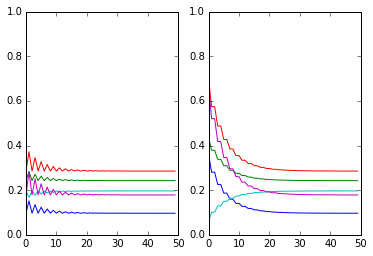

In [16]:
#let sys/bath interact
num_steps = 25

store_visible = []
store_hidden = []
for _ in range(num_steps):

    #update bath (doesn't do anything in this case)
    data_prob.refresh(bath_probs)
    
    #interact with bath
    sys.interact_with_bath(data_prob)
    store_visible.append(list(sys.visible_probs))
    store_hidden.append(list(sys.hidden_probs))
    
    #system self-interaction
    sys.evolve(1,print_states=False)
    store_visible.append(list(sys.visible_probs))
    store_hidden.append(list(sys.hidden_probs))

store_visible = np.array(store_visible)
store_hidden = np.array(store_hidden)
    
ax1=plt.subplot(1,2,1);
plt.plot(store_visible);
plt.subplot(1,2,2,sharey = ax1);
plt.plot(store_hidden);
ax1.set_ylim([0.0,1.0]);

In [17]:
print sys.visible_probs
print sys.hidden_probs
print bath_probs

[ 0.09665012  0.24262835  0.28556487  0.19664088  0.17856491]
[ 0.09667479  0.2426466   0.28560355  0.19662807  0.17861075]
[ 0.09663954  0.24262053  0.28554829  0.19664637  0.17854527]


All subsystems (visible, hidden, bath) are in equilibrium

### Use binary encoding for bath 
(binary values chosen stochastically based on probabilities)

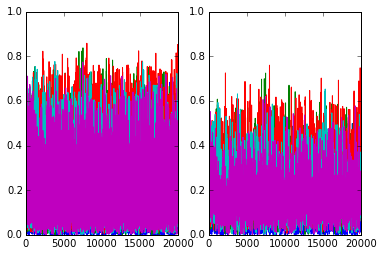

In [18]:
#let sys/bath interact for long time
num_steps = 10000

store_visible = []
store_hidden = []
store_bath = []

for ctr in range(0,num_steps):

    #update bath
    data_binary.refresh(prob_to_binary(bath_probs))
    store_bath.append(data_binary.probs)
    
    #interact with bath
    sys.interact_with_bath(data_binary)
    store_visible.append(list(sys.visible_probs))
    store_hidden.append(list(sys.hidden_probs))
    
    #system self-interaction
    sys.evolve(1,print_states=False)
    store_visible.append(list(sys.visible_probs))
    store_hidden.append(list(sys.hidden_probs))

#evolve without bath    
#for ctr in range(0,num_steps):   
#    sys.evolve(1,print_states=False)
#    store_visible.append(list(sys.visible_probs))
#    store_hidden.append(list(sys.hidden_probs))    

store_visible = np.array(store_visible)
store_hidden = np.array(store_hidden)
store_bath = np.array(store_bath)

    
ax1=plt.subplot(1,2,1);
plt.plot(store_visible);
plt.subplot(1,2,2,sharey = ax1);
plt.plot(store_hidden);
ax1.set_ylim([0.0,1.0]);


In [19]:
print np.mean(store_visible[1000:-1,:],axis=0) #ignoring "burn-in" period
print np.mean(store_hidden[1000:-1,:],axis=0) #ignoring "burn-in" period
print bath_probs

[ 0.09572756  0.23628451  0.28645729  0.19555559  0.17543565]
[ 0.09575195  0.2362442   0.28651505  0.19564157  0.17541294]
[ 0.09663954  0.24262053  0.28554829  0.19664637  0.17854527]


All levels are once again in equilibrium (on average)

# Average bath state over N most recent realizations

In [20]:
store_recent_states = []
store_binary = []
for _ in range(10):
    data_binary.refresh(prob_to_binary(bath_probs)) #choose new realizations
    store_binary.append(list(data_binary.state))
store_binary = np.array(store_binary)
print store_binary
print store_binary.mean(axis=0)

[[0 1 1 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 1 0 0 0]
 [0 0 1 1 0]
 [0 0 0 0 1]
 [0 1 0 0 0]
 [0 0 0 0 0]]
[ 0.   0.4  0.3  0.1  0.2]


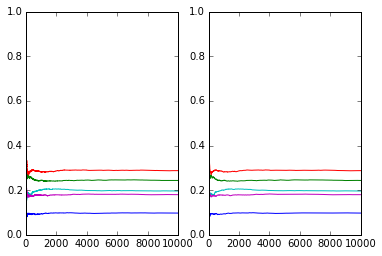

In [11]:
#let sys/bath interact for long time
num_steps = 5000
N = 10

store_visible = []
store_hidden = []
store_bath = []
store_recent_bath_states = []

for ctr in range(num_steps):

    #update bath
    for _ in range(N):
        data_binary.refresh(prob_to_binary(bath_probs)) #choose new realizations
        store_recent_bath_states.append(list(data_binary.state)) 
    recent_bath_avg_probs = np.array(store_recent_bath_states).mean(axis=0) #average realizations over N steps
    data_prob.refresh(recent_bath_avg_probs) #use these averages as probabilities for bath
    store_bath.append(data_prob.probs)
    
    #interact with bath
    sys.interact_with_bath(data_prob)
    store_visible.append(list(sys.visible_probs))
    store_hidden.append(list(sys.hidden_probs))
    
    #system self-interaction
    sys.evolve(1,print_states=False)
    store_visible.append(list(sys.visible_probs))
    store_hidden.append(list(sys.hidden_probs))

#evolve without bath    
#for ctr in range(0,num_steps):   
#    sys.evolve(1,print_states=False)
#    store_visible.append(list(sys.visible_probs))
#    store_hidden.append(list(sys.hidden_probs))    

store_visible = np.array(store_visible)
store_hidden = np.array(store_hidden)
store_bath = np.array(store_bath)

    
ax1=plt.subplot(1,2,1);
plt.plot(store_visible);
plt.subplot(1,2,2,sharey = ax1);
plt.plot(store_hidden);
ax1.set_ylim([0.0,1.0]);


In [12]:
print np.mean(store_visible[1000:-1,:],axis=0) #ignoring "burn-in" period
print np.mean(store_hidden[1000:-1,:],axis=0) #ignoring "burn-in" period
print bath_probs

[ 0.09741513  0.24417189  0.28822218  0.19907161  0.18034183]
[ 0.09741336  0.24417233  0.28821826  0.19907376  0.18034026]
[ 0.09663954  0.24262053  0.28554829  0.19664637  0.17854527]


### Questions:

- The evolution here is just mixing. What happens when I use a different type of evolution, e.g., typical neural network activations, or q.mechanical unitary evolution, or a master/rate equation?

- What is the difference between the probability and binary valued baths?

- Why might we want a binary-valued representation?
    - At least for the bath, it's all we have really, since we don't have probabilities from data (except by taking huge averages)

- What is the best way to represent everything as systems and subsystems?
    - I'm guessing that we want each layer $L=B_V,S_V,S_H$ to be its own system, with corresponding energy function $H_L$. 
    - If each layer contains N binary units, we would want to encode $N$ 2-level subsystems. 
    - Since we have a restricted Boltzmann machine, the energy function of a given layer does not couple these 2-level pieces, so $H^L = \sum_{k=1}^N H_k^L$, where $H_k^L$ only acts on subsystem $k$ of layer $L$.
    - WLOG, we can take $H^L_k=E_k\sigma_z$ for all units (how does this connect to a bias?)
    - With this formalism, we can represent interactions between the bath and visible layer, or visible and hidden layer, via interactions $H_{BV}$ and $H_{VH}$
    - The standard neural network update rule is $h_i = \sigma(w_i v+b^H_i)$, i.e., "if activation energy is low, don't activate, if activation energy is high, activate, and if energy is in middle, choose 50/50"

- Do I want hidden and visible units to be in same state??? This seems to break the expressiveness...